# Install Libraries if Needed (Only Run Once)

In [65]:
!pip install -U deepxde
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install -U tensorflow
!pip install -U "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.
!pip install ipympl


In [66]:
!pip install -U ipython

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 790 kB 14.6 MB/s            


# Import Libraries

In [4]:
# Interactive Plotting

# for jupyter notebooks
# %matplotlib notebook 

# for jupyter labs
%matplotlib widget 

UsageError: unrecognized arguments: # for jupyter labs


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint

Using backend: tensorflow.compat.v1

2021-11-16 13:18:13.640624: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term



# Burgers Equation

# Define Generate Test Data Function

In [2]:
def gen_testdata():
    data = np.load("dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    Nx = len(x)
    Nt = len(t)
    return X, y, Nx, Nt

# Define PDE

In [3]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

# Define Geometry

In [4]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define ICs/BCs

In [5]:
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Construct Data (geometry + PDE + ICs/BCs)

In [6]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160)

/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


# Define Network Architecture

In [7]:
net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

# Define Model (data + net)

In [8]:
model = dde.Model(data, net)

# Train the Model
Here we train the model twice.  Once with Adam optimizer for initial training.  Then again with L-BFGS-B optimizer for finetuning.

In [9]:
model.compile("adam", lr=1e-3)
model.train(epochs=15000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.053103 s



/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-11-16 12:59:21.010363: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-16 12:59:21.370992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemory

'compile' took 1.222217 s

Initializing variables...
Training model...



2021-11-16 12:59:22.209651: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3783000000 Hz
2021-11-16 12:59:22.299772: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


Step      Train loss                        Test loss                         Test metric
0         [2.20e-02, 7.02e-03, 4.66e-01]    [2.20e-02, 7.02e-03, 4.66e-01]    []  


2021-11-16 12:59:22.589606: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1000      [3.80e-02, 2.07e-04, 5.10e-02]    [3.80e-02, 2.07e-04, 5.10e-02]    []  
2000      [1.83e-02, 9.10e-05, 2.21e-02]    [1.83e-02, 9.10e-05, 2.21e-02]    []  
3000      [5.04e-03, 3.26e-05, 5.36e-03]    [5.04e-03, 3.26e-05, 5.36e-03]    []  
4000      [2.58e-03, 3.39e-06, 2.38e-03]    [2.58e-03, 3.39e-06, 2.38e-03]    []  
5000      [1.79e-03, 6.18e-06, 1.60e-03]    [1.79e-03, 6.18e-06, 1.60e-03]    []  
6000      [1.45e-03, 2.91e-06, 1.24e-03]    [1.45e-03, 2.91e-06, 1.24e-03]    []  
7000      [1.22e-03, 3.15e-06, 1.04e-03]    [1.22e-03, 3.15e-06, 1.04e-03]    []  
8000      [1.29e-03, 6.43e-06, 9.70e-04]    [1.29e-03, 6.43e-06, 9.70e-04]    []  
9000      [9.49e-04, 5.46e-06, 8.06e-04]    [9.49e-04, 5.46e-06, 8.06e-04]    []  
10000     [8.50e-04, 2.13e-06, 6.78e-04]    [8.50e-04, 2.13e-06, 6.78e-04]    []  
11000     [6.21e-04, 1.21e-06, 6.11e-04]    [6.21e-04, 1.21e-06, 6.11e-04]    []  
12000     [7.82e-04, 1.19e-06, 5.23e-04]    [7.82e-04, 1.19e-06, 5.23e-04]    []  
1300

Saving loss history to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/loss_Burgers.dat ...
Saving training data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/train_Burgers.dat ...
Saving test data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/test_Burgers.dat ...


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
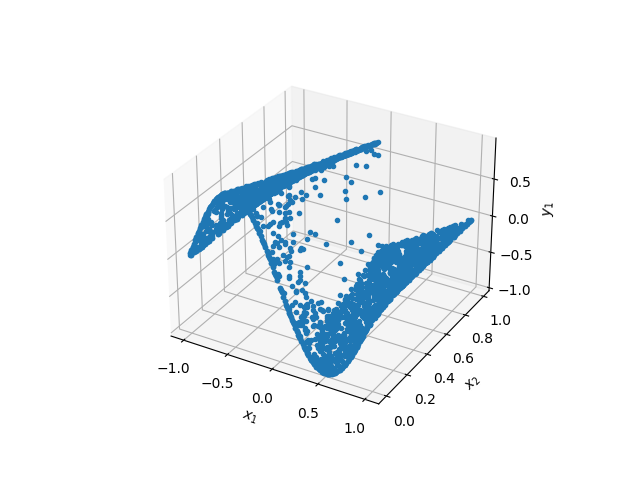

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
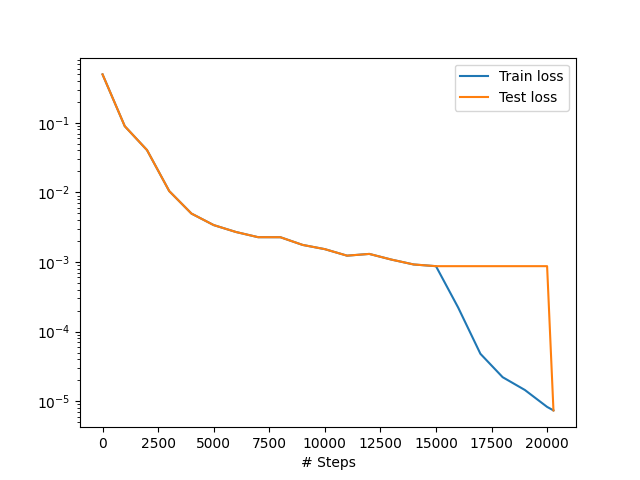

In [10]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname='loss_Burgers.dat', train_fname='train_Burgers.dat',test_fname='test_Burgers.dat')


# Optionally Refine by Adding Additional Points Near Potential Shock (True Shock Occurs at Low to Zero Viscosity)

In [11]:
X_reample = geomtime.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X_reample, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X_reample[x_id], "\n")
    data.add_anchors(X_reample[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(
        epochs=10000, disregard_previous_best=True, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()

Mean residual: 4.750e-03
Adding new point: [0.00244403 0.42870548] 

Compiling model...
'compile' took 0.289076 s

Training model...

Step      Train loss                        Test loss                         Test metric
20286     [2.66e-03, 2.00e-08, 5.45e-07]    [6.83e-06, 2.00e-08, 5.45e-07]    []  
21000     [3.62e-05, 1.73e-08, 1.71e-05]    [3.47e-05, 1.73e-08, 1.71e-05]    []  
22000     [2.17e-05, 2.72e-08, 1.11e-05]    [2.12e-05, 2.72e-08, 1.11e-05]    []  
23000     [1.93e-05, 3.95e-08, 6.23e-06]    [1.91e-05, 3.95e-08, 6.23e-06]    []  
Epoch 23000: early stopping

Best model at step 23000:
  train loss: 2.56e-05
  test loss: 2.54e-05
  test metric: []

'train' took 8.482418 s

Compiling model...
'compile' took 0.195505 s

Training model...

Step      Train loss                        Test loss                         Test metric
23000     [1.93e-05, 3.95e-08, 6.23e-06]    [1.91e-05, 3.95e-08, 6.23e-06]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVE

Saving loss history to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/loss_Burgers_RAR.dat ...
Saving training data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/train_Burgers_RAR.dat ...
Saving test data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/test_Burgers_RAR.dat ...


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
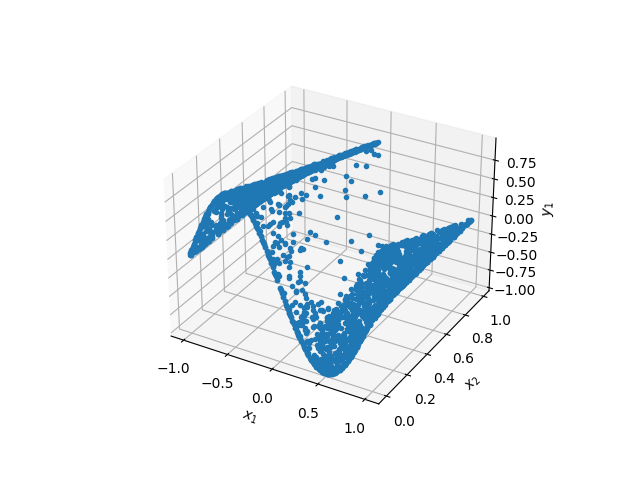

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
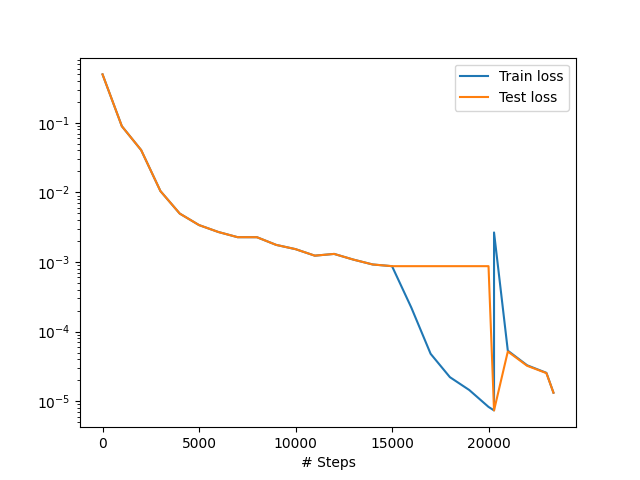

In [12]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname='loss_Burgers_RAR.dat', train_fname='train_Burgers_RAR.dat',test_fname='test_Burgers_RAR.dat')


# Load the Test Data

In [17]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.011980504038749444


In [15]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
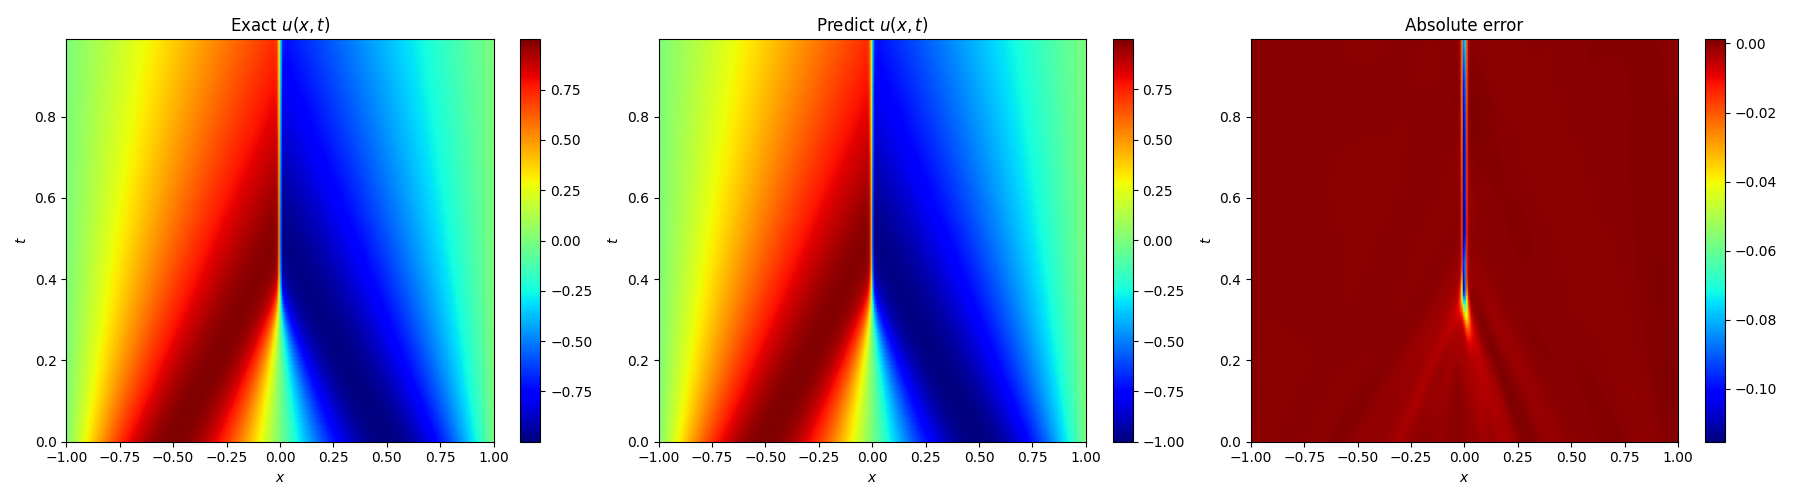

In [16]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [26]:
x = np.linspace(-1.0,1.0,Nx)


(256,)

In [25]:
Nx

256

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
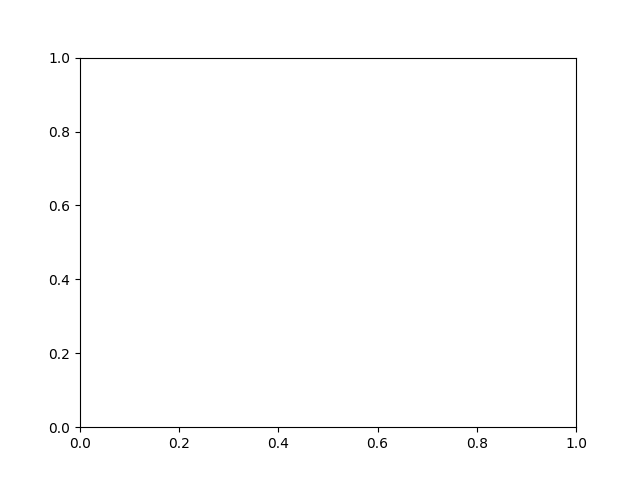

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
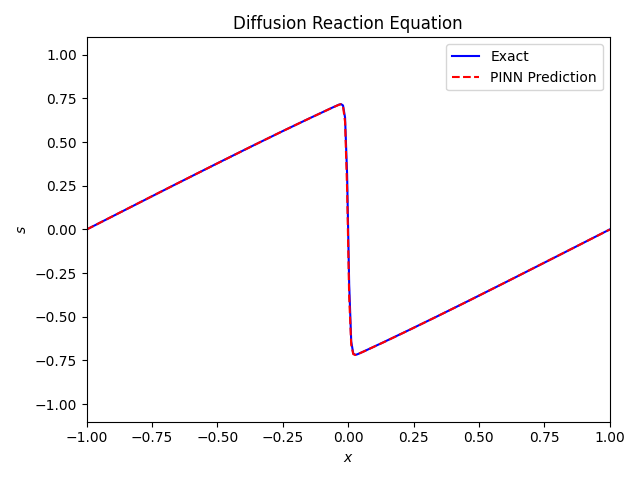

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, Y_test[0], 'b-', label='Exact')
ax.plot(x, Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(x, Y_test[i], 'b-', label='Exact')
    ax.plot(x, Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()

In [49]:
T_test

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       ...,
       [0.97, 0.97, 0.97, ..., 0.97, 0.97, 0.97],
       [0.98, 0.98, 0.98, ..., 0.98, 0.98, 0.98],
       [0.99, 0.99, 0.99, ..., 0.99, 0.99, 0.99]])

In [ ]:

fig = plt.figure()

In [27]:
y_pred

array([[-0.00086122],
       [ 0.0238348 ],
       [ 0.04852367],
       ...,
       [-0.01217001],
       [-0.00626262],
       [-0.00036088]], dtype=float32)

In [28]:
y_true

array([[ 1.22464680e-16],
       [ 2.46374492e-02],
       [ 4.92599411e-02],
       ...,
       [-1.19673204e-02],
       [-5.98368729e-03],
       [ 1.12388795e-16]])

In [29]:
X

array([[-1.        ,  0.        ],
       [-0.99215686,  0.        ],
       [-0.98431373,  0.        ],
       ...,
       [ 0.98431373,  0.99      ],
       [ 0.99215686,  0.99      ],
       [ 1.        ,  0.99      ]])

In [30]:
X.shape

(25600, 2)

In [ ]:
np.sqr